In [1]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import numpy as np
from scipy import spatial
from astropy.table import Table
from astropy.cosmology import LambdaCDM as Cos
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
from IPython import display 
from scipy import stats
from scipy.interpolate import interp1d
from scipy.stats import norm
import fitsio

import pickle
import dask

In [2]:
from dask.distributed import progress
#import ipywidgets

In [18]:
import dask
from dask.distributed import Client
dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{host}:{port}/status"

```bash
export OMP_NUM_THREADS=2
module load python
source activate nersc_clusters
cd $SCRATCH
rm -rf scheduler.json
salloc \
        -N 1 \
        -n 32 \
        -c 2 \
        -t 230 \
        -C haswell \
        -q interactive \
        srun -u python -u \
            $(which dask-mpi) \
                --scheduler-file=scheduler.json \
                --dashboard-address=0 \
                --memory-limit='auto' \
                --no-nanny \
                --local-directory=/tmp
                
```

In [70]:
import os

scheduler_file = os.path.join(os.environ["SCRATCH"], "scheduler.json")
client = Client(scheduler_file=scheduler_file)

In [71]:
client

Client Scheduler: tcp://10.128.0.22:41287 Dashboard: /user/mjyb16/cori-shared-node-cpu/proxy/10.128.0.22:37321/status,Cluster Workers: 31 Cores: 62 Memory: 3.57 TiB


In [72]:
table_of_centers = pd.read_csv("list_of_sweeps.csv")

In [73]:
table_of_centers_sorted = table_of_centers.sort_values(by = "patch").copy().reset_index()

In [74]:
table_of_centers_n = table_of_centers_sorted[0:61].copy()
table_of_centers_s = table_of_centers_sorted[61:].copy()

In [75]:
for i in range(0, len(table_of_centers_s)):
    table_of_centers_s.at[i, "patch"] = '/global/cscratch1/sd/mjyb16/DR9/south/sweep' + table_of_centers_s.iloc[i].patch[71:]
    table_of_centers_s.at[i, "photoz"] = '/global/cscratch1/sd/mjyb16/DR9/south/photo-z' + table_of_centers_s.iloc[i].photoz[79:]
    table_of_centers_s.at[i, "masses"] = '/global/cscratch1/sd/mjyb16/DR9/south/stellar_mass' + table_of_centers_s.iloc[i].masses[70:]

for i in range(0, len(table_of_centers_n)):
    table_of_centers_n.at[i, "patch"] = '/global/cscratch1/sd/mjyb16/DR9/north/sweep' + table_of_centers_n.iloc[i].patch[71:]
    table_of_centers_n.at[i, "photoz"] = '/global/cscratch1/sd/mjyb16/DR9/north/photo-z' + table_of_centers_n.iloc[i].photoz[79:]
    table_of_centers_n.at[i, "masses"] = '/global/cscratch1/sd/mjyb16/DR9/north/stellar_mass' + table_of_centers_n.iloc[i].masses[70:]

In [76]:
def data_import(maxx, maxy, minx, miny, row2):
    fits_data = fitsio.FITS(row2.patch)
    sweep = fits_data[1].read(columns=['RELEASE','BRICKID','BRICKNAME', 'OBJID', 'TYPE', 'RA', 'DEC', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'MASKBITS', 'GAIA_PHOT_G_MEAN_MAG', 'GAIA_ASTROMETRIC_EXCESS_NOISE'])
    data = Table.read(row2.photoz, format = "fits")
    pz = data.to_pandas()
    #with fits.open(row2.photoz) as data:
    #    pz = pd.DataFrame(data[1].data)
    mass = np.load(row2.masses)
    
    pz['mass'] = mass
    pz['RELEASE']=sweep['RELEASE']
    pz['BRICKID']=sweep['BRICKID']
    pz['BRICKNAME']=sweep['BRICKNAME']
    pz['OBJID']=sweep['OBJID']
    pz['TYPE']=sweep['TYPE']
    pz['RA']=sweep['RA']
    pz['DEC']=sweep['DEC']
    pz['FLUX_G']=sweep['FLUX_G']
    pz['FLUX_R']=sweep['FLUX_R']
    pz['FLUX_Z']=sweep['FLUX_Z']
    pz['FLUX_W1']=sweep['FLUX_W1']
    pz['MASKBITS']=sweep['MASKBITS']
    pz['gaia_phot_g_mean_mag']=sweep['GAIA_PHOT_G_MEAN_MAG']
    pz['gaia_astrometric_excess_noise']=sweep['GAIA_ASTROMETRIC_EXCESS_NOISE']
    pz = pz[np.logical_and.reduce((pz.RA < maxx + buffer/np.cos(pz.DEC*(np.pi/180)), pz.DEC < maxy + buffer, pz.RA > minx - buffer/np.cos(pz.DEC*(np.pi/180)), pz.DEC > miny - buffer))]
    return pz

def data_importer(row):
    fits_data = fitsio.FITS(row.patch)
    sweep = fits_data[1].read(columns=['RA', 'DEC'])
    maxx = max(sweep['RA'])
    maxy = max(sweep['DEC'])
    minx = min(sweep['RA'])
    miny = min(sweep['DEC'])

    maxRA = max(sweep['RA'])
    maxDEC = max(sweep['DEC'])
    minRA = min(sweep['RA'])
    minDEC = min(sweep['DEC'])

    ra_dec = data_import(maxx, maxy, minx, miny, row)
    #Initial sample cuts
    zmag=np.array(22.5-2.5*np.log10(ra_dec.FLUX_Z))
    zmag[np.where(~np.isfinite(zmag))]=99.
    #whgood=np.where(np.logical_and(zmag < 21,ra_dec.mass > 0 ))
    isgood=np.logical_and(zmag < 21,ra_dec.mass > 0)
    ra_dec = ra_dec[isgood]

    #Further sample cuts
    ra_dec = ra_dec[np.logical_or(ra_dec.MASKBITS == 0, ra_dec.MASKBITS == 4096)]
    ra_dec = ra_dec[np.logical_or(np.logical_or(ra_dec.gaia_phot_g_mean_mag > 19, ra_dec.gaia_astrometric_excess_noise > 10**.5), ra_dec.gaia_astrometric_excess_noise==0)]
    ra_dec["magR"] = 22.5-2.5*np.log10(ra_dec.FLUX_R)
    ra_dec["magZ"] = 22.5-2.5*np.log10(ra_dec.FLUX_Z)
    ra_dec["magW1"] = 22.5-2.5*np.log10(ra_dec.FLUX_W1)
    l_mask = (ra_dec.magR - ra_dec.magW1) > 1.8*(ra_dec.magR-ra_dec.magZ)-0.6
    l_mask[~np.isfinite(l_mask)] = False
    #ra_dec = ra_dec[l_mask]
    ra_dec = ra_dec[np.logical_and(22.5 - 2.5*np.log10(ra_dec.FLUX_Z)<21, ra_dec.Z_PHOT_MEDIAN>0.01)]
    ra_dec = ra_dec[ra_dec.TYPE != "PSF"]

    #Coordinates
    ra_dec["RA_r"] = (np.pi/180)*ra_dec["RA"]
    ra_dec["DEC_r"] = (np.pi/180)*ra_dec["DEC"]
    ra_dec["gid"] = np.round(ra_dec.RA, 6)*10**16 + np.round(ra_dec.DEC + 90, 6)*10**6

    ra_dec.reset_index(inplace = True, drop = True)
    over = np.array([ra_dec.Z_PHOT_MEDIAN.values]).T*np.ones((len(ra_dec), oversample))
    sigma = np.array([ra_dec.Z_PHOT_STD.values]).T*np.ones((len(ra_dec), oversample))
    random = np.random.normal(loc = 0, scale = 1, size = (len(ra_dec), oversample))
    gauss = over + sigma*random
    ra_dec["gauss_z"] = pd.Series(list(gauss))

    ra_dec["y"] = ra_dec["DEC_r"] - np.mean(ra_dec["DEC_r"]) + 50
    ra_dec["x"] = (ra_dec["RA_r"] - np.mean(ra_dec["RA_r"]))*np.cos(ra_dec["DEC_r"]) + 50
    return ra_dec

In [4]:
a = 1.3620186928378857  
b = 9.968545069745126
j= 1.04935943 
k = 0.39573094 
l = 0.28347756
oversample = 30
buffer = 0.285
def mass_limit(z):
    return np.minimum((a*z + b), 11.2)

def mass_coefficient(z):
    return np.exp(j*z**2 + k*z + l)

radius = 1
small_radius = 0.5
mini_radius = 0.1

z_bins = np.arange(0.05, 1.5, 0.01)

In [78]:
@dask.delayed()
def background_counter(data, ra, dec, mra, mdec):
    ra_dec = data_importer(data)
    if len(ra_dec) == 0:
        return []
    y = (np.pi/180)*dec - (np.pi/180)*mdec + 50
    x = (np.pi/180)*(ra - mra)*np.cos((np.pi/180)*dec) + 50
    #y = 50
    #x = 50
    cos = Cos(H0 = 70, Om0 = .286, Ode0 = .714)
    z_array = np.linspace(1e-2, ra_dec.Z_PHOT_MEDIAN.max(), 500)
    sparse_radius = (1+z_array)/(cos.comoving_distance(z_array))
    radius_threshold = interp1d(z_array, sparse_radius, kind = "linear", fill_value = "extrapolate")
    median = stats.binned_statistic(ra_dec.Z_PHOT_MEDIAN, ra_dec.Z_PHOT_STD, "median", bins = np.linspace(0.05, ra_dec.Z_PHOT_MEDIAN.max(), 100))
    bins = np.linspace(0.05, ra_dec.Z_PHOT_MEDIAN.max(), 99)
    z_threshold = interp1d(bins, median[0], kind = "linear", fill_value = "extrapolate")
    
    indexable = ra_dec[["Z_PHOT_MEDIAN", "x", "y", "mass", "gauss_z", "FLUX_G", "FLUX_Z"]].values.copy()
    tree = spatial.cKDTree(ra_dec[["x", "y"]], copy_data = True)
    neighbors = tree.query_ball_point([x, y], radius_threshold(0.02))
    onempc = np.zeros(len(z_bins))
    halfmpc = np.zeros(len(z_bins))
    tenthmpc = np.zeros(len(z_bins))
    
    if len(neighbors) > 0:
        for i in range(len(z_bins)):
            local_data = indexable[neighbors]

            z_c = z_threshold(z_bins[i])
            cylinder = np.abs(np.vstack(local_data[:, 4]) - z_bins[i])
            weight_array = cylinder < 2*z_c
            weights = weight_array.sum(axis = 1)/oversample

            approx_cluster = np.append(local_data, np.reshape(weights, newshape = (len(weights), 1)), axis = 1)
            cluster = approx_cluster[approx_cluster[:, -1] > 0]

            r_smaller = radius_threshold(z_bins[i])
            large_cluster = cluster[np.sqrt(np.array((cluster[:, 1] - x)**2 + (cluster[:, 2] - y)**2).astype(float)) < r_smaller]
            small_cluster = cluster[np.sqrt(np.array((cluster[:, 1] - x)**2 + (cluster[:, 2] - y)**2).astype(float)) < 0.5*r_smaller]
            mini_cluster = cluster[np.sqrt(np.array((cluster[:, 1] - x)**2 + (cluster[:, 2] - y)**2).astype(float)) < 0.1*r_smaller]

            onempc[i] = np.sum(large_cluster[:, -1])
            halfmpc[i] = np.sum(small_cluster[:, -1])
            tenthmpc[i] = np.sum(mini_cluster[:, -1])
            
    #print(inty)
    del ra_dec, indexable, tree, neighbors
    return [onempc, halfmpc, tenthmpc]

In [79]:
np.random.seed(1)

In [29]:
table_of_centers_n

,index,Unnamed: 0,Unnamed: 0.1,patch,mean_RA,mean_DEC,photoz,masses
0,13,453,453,/global/cscratch1/sd/mjyb16/DR9/north/sweep/sw...,4.980352,-0.743755,/global/cscratch1/sd/mjyb16/DR9/north/photo-z/...,/global/cscratch1/sd/mjyb16/DR9/north/stellar_...
1,46,557,557,/global/cscratch1/sd/mjyb16/DR9/north/sweep/sw...,15.031653,30.107015,/global/cscratch1/sd/mjyb16/DR9/north/photo-z/...,/global/cscratch1/sd/mjyb16/DR9/north/stellar_...
2,58,547,547,/global/cscratch1/sd/mjyb16/DR9/north/sweep/sw...,37.735417,1.264987,/global/cscratch1/sd/mjyb16/DR9/north/photo-z/...,/global/cscratch1/sd/mjyb16/DR9/north/stellar_...
3,54,495,495,/global/cscratch1/sd/mjyb16/DR9/north/sweep/sw...,67.333743,68.931077,/global/cscratch1/sd/mjyb16/DR9/north/photo-z/...,/global/cscratch1/sd/mjyb16/DR9/north/stellar_...
4,108,580,580,/global/cscratch1/sd/mjyb16/DR9/north/sweep/sw...,104.931769,37.440121,/global/cscratch1/sd/mjyb16/DR9/north/photo-z/...,/global/cscratch1/sd/mjyb16/DR9/north/stellar_...
...,...,...,...,...,...,...,...,...
56,18,550,550,/global/cscratch1/sd/mjyb16/DR9/north/sweep/sw...,331.695614,-0.586413,/global/cscratch1/sd/mjyb16/DR9/north/photo-z/...,/global/cscratch1/sd/mjyb16/DR9/north/stellar_...
57,55,586,586,/global/cscratch1/sd/mjyb16/DR9/north/sweep/sw...,332.969789,1.531616,/global/cscratch1/sd/mjyb16/DR9/north/photo-z/...,/global/cscratch1/sd/mjyb16/DR9/north/stellar_...
58,118,484,484,/global/cscratch1/sd/mjyb16/DR9/north/sweep/sw...,338.764116,29.134670,/global/cscratch1/sd/mjyb16/DR9/north/photo-z/...,/global/cscratch1/sd/mjyb16/DR9/north/stellar_...
59,73,448,448,/global/cscratch1/sd/mjyb16/DR9/north/sweep/sw...,349.874985,-1.348225,/global/cscratch1/sd/mjyb16/DR9/north/photo-z/...,/global/cscratch1/sd/mjyb16/DR9/north/stellar_...


In [40]:
results_n = []
for it in range(0, 44):
    data_r = table_of_centers_n.iloc[it]
    fits_data = fitsio.FITS(data_r.patch)
    sweep = fits_data[1].read(columns=['RA', 'DEC'])
    maxx = max(sweep['RA'])
    maxy = max(sweep['DEC'])
    minx = min(sweep['RA'])
    miny = min(sweep['DEC'])
    mra = np.mean(sweep['RA'])
    mdec = np.mean(sweep['DEC'])
    for i in range(20):
        ra = np.random.uniform(low = minx, high = maxx)
        dec = np.random.uniform(low = miny, high = maxy)
        #print(((np.pi/180)*(ra - mra), (np.pi/180)*(dec - mdec)))
        results_n.append(background_counter(data_r, ra, dec, mra, mdec))

(0.02760015854058456, 0.00905014536228167)
(0.04296773705819607, 0.005445540298781312)
(0.06324875336452986, 0.010998901025060919)
(0.07080338656753363, -0.003947485860225097)
(-0.07197282564535896, 0.008350397588799918)
(0.0074232881149599705, 0.0002005120205616819)
(0.05738180702710062, -0.014259405948695698)
(0.06659446083676993, -0.014184289816449978)
(0.03434702189906049, 0.0014877321438913997)
(0.025368189619712496, -0.004561781924720829)
(-0.03856040961410214, -0.0007255375109403305)
(0.06796674837330892, 0.0008585610612030643)
(0.02910311045710987, -0.0026540109719478252)
(0.08303159295979545, 0.005882697173671895)
(-0.024695552986177174, 0.0033599979283959005)
(0.00806641153243789, 0.009894849253644498)
(-0.03863161415227144, -0.012102621775902355)
(-0.05325420136733941, -0.004194224785904242)
(0.06242305219654907, -0.007488261224323047)
(0.022682085911179893, 0.0025101566151317072)
(0.00011205375187119613, -0.00024313019737323788)
(0.0023527702083198433, -6.557590558828693e-0

KeyboardInterrupt: 

In [31]:
background_n = dask.persist(*results_n)
#progress(background_n)

In [32]:
background_n = dask.compute(*background_n)

In [34]:
len(background_n)

880

In [48]:
np.shape(background_n[40])

(3, 145)

In [49]:
original_1 = background_n[40][0].reshape((len(background_n[40][0]), 1))
original_05 = background_n[40][1].reshape((len(background_n[40][0]), 1))
original_01 = background_n[40][2].reshape((len(background_n[40][0]), 1))
for i in range(41, 880):
    if len(background_n[i]) > 0:
        original_1 = np.append(original_1, background_n[i][0].reshape((len(background_n[40][0]), 1)), axis = 1)
        original_05 = np.append(original_05, background_n[i][1].reshape((len(background_n[40][0]), 1)), axis = 1)
        original_01 = np.append(original_01, background_n[i][2].reshape((len(background_n[40][0]), 1)), axis = 1)

In [50]:
len(original_1[0])

680

In [51]:
np.save("third_north_monte_carlo_background_1", original_1)
np.save("third_north_monte_carlo_background_05", original_05)
np.save("third_north_monte_carlo_background_01", original_01)

In [17]:
background_n = np.load("third_south_monte_carlo_background_1.npy")

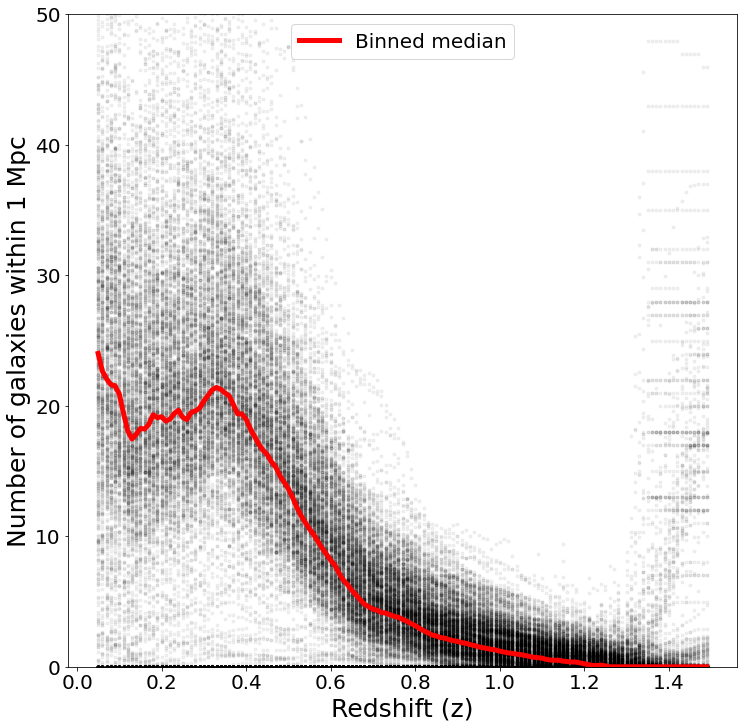

In [18]:
plt.figure(figsize = (12, 12))
for i in range(680):
    if len(background_n[:, i]) > 0:
        medians = background_n[:, i].copy()
        plt.plot(z_bins, medians, ".k", alpha = 0.05)
        #plt.plot(z_bins, background_n[i][1], "-")
        #plt.plot(z_bins, background_n[i][2], "-")
plt.plot(z_bins, np.median(background_n, axis = 1), "-r", lw = 5, label = "Binned median")
plt.ylabel("Number of galaxies within 1 Mpc", fontsize = 25)
plt.xlabel("Redshift (z)", fontsize = 25)
plt.ylim(0, 50)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 20)
plt.savefig('background_south.pdf')
plt.show()

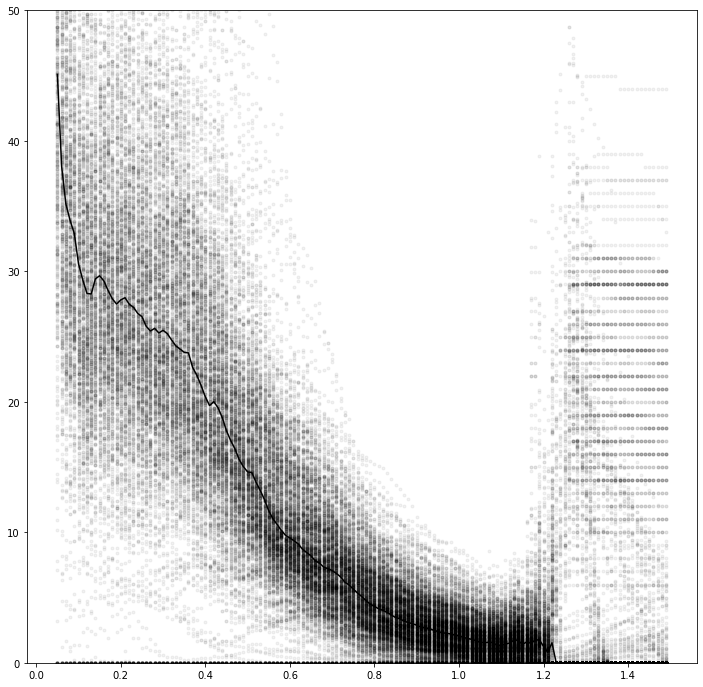

In [53]:
plt.figure(figsize = (12, 12))
for i in range(880):
    if len(background_n[i]) > 0:
        plt.plot(z_bins, background_n[i][0], ".k", alpha = 0.05)
        #plt.plot(z_bins, background_n[i][1], "-")
        #plt.plot(z_bins, background_n[i][2], "-")
plt.plot(z_bins, np.median(original_1, axis = 1), "-r", lw = 5, label = "Binned median")
plt.ylim(0, 50)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

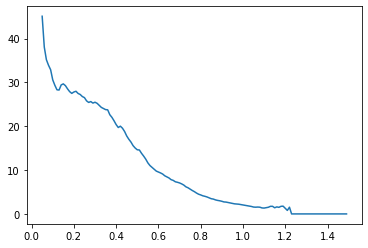

In [54]:
plt.plot(z_bins, np.median(original_1, axis = 1))

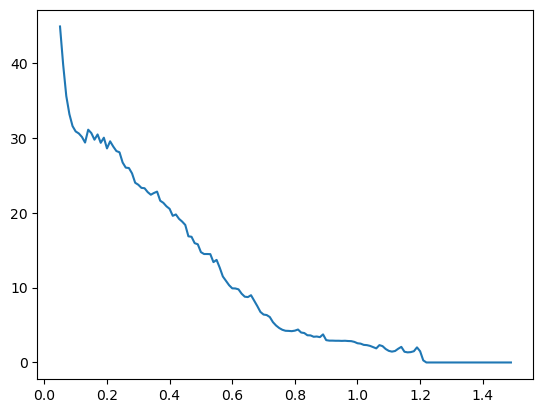

In [25]:
plt.plot(z_bins, np.median(original_1, axis = 1))

In [80]:
def data_import(maxx, maxy, minx, miny, row2):
    fits_data = fitsio.FITS(row2.patch)
    sweep = fits_data[1].read(columns=['RELEASE','BRICKID','BRICKNAME', 'OBJID', 'TYPE', 'RA', 'DEC', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'MASKBITS', 'GAIA_PHOT_G_MEAN_MAG', 'GAIA_ASTROMETRIC_EXCESS_NOISE'])
    data = Table.read(row2.photoz, format = "fits")
    pz = data.to_pandas()
    #with fits.open(row2.photoz) as data:
    #    pz = pd.DataFrame(data[1].data)
    mass = np.load(row2.masses)
    
    pz['mass'] = mass
    pz['RELEASE']=sweep['RELEASE']
    pz['BRICKID']=sweep['BRICKID']
    pz['BRICKNAME']=sweep['BRICKNAME']
    pz['OBJID']=sweep['OBJID']
    pz['TYPE']=sweep['TYPE']
    pz['RA']=sweep['RA']
    pz['DEC']=sweep['DEC']
    pz['FLUX_G']=sweep['FLUX_G']
    pz['FLUX_R']=sweep['FLUX_R']
    pz['FLUX_Z']=sweep['FLUX_Z']
    pz['FLUX_W1']=sweep['FLUX_W1']
    pz['MASKBITS']=sweep['MASKBITS']
    pz['gaia_phot_g_mean_mag']=sweep['GAIA_PHOT_G_MEAN_MAG']
    pz['gaia_astrometric_excess_noise']=sweep['GAIA_ASTROMETRIC_EXCESS_NOISE']
    pz = pz[np.logical_and.reduce((pz.RA < maxx + buffer/np.cos(pz.DEC*(np.pi/180)), pz.DEC < maxy + buffer, pz.RA > minx - buffer/np.cos(pz.DEC*(np.pi/180)), pz.DEC > miny - buffer))]
    return pz

def data_importer(row):
    fits_data = fitsio.FITS(row.patch)
    sweep = fits_data[1].read(columns=['RA', 'DEC'])
    maxx = max(sweep['RA'])
    maxy = max(sweep['DEC'])
    minx = min(sweep['RA'])
    miny = min(sweep['DEC'])

    maxRA = max(sweep['RA'])
    maxDEC = max(sweep['DEC'])
    minRA = min(sweep['RA'])
    minDEC = min(sweep['DEC'])

    ra_dec = data_import(maxx, maxy, minx, miny, row)
    #Initial sample cuts
    zmag=np.array(22.5-2.5*np.log10(ra_dec.FLUX_Z))
    zmag[np.where(~np.isfinite(zmag))]=99.
    #whgood=np.where(np.logical_and(zmag < 21,ra_dec.mass > 0 ))
    isgood=np.logical_and(zmag < 21,ra_dec.mass > 0)
    ra_dec = ra_dec[isgood]

    #Further sample cuts
    ra_dec = ra_dec[np.logical_or(ra_dec.MASKBITS == 0, ra_dec.MASKBITS == 4096)]
    ra_dec = ra_dec[np.logical_or(np.logical_or(ra_dec.gaia_phot_g_mean_mag > 19, ra_dec.gaia_astrometric_excess_noise > 10**.5), ra_dec.gaia_astrometric_excess_noise==0)]
    ra_dec["magR"] = 22.5-2.5*np.log10(ra_dec.FLUX_R)
    ra_dec["magZ"] = 22.5-2.5*np.log10(ra_dec.FLUX_Z)
    ra_dec["magW1"] = 22.5-2.5*np.log10(ra_dec.FLUX_W1)
    l_mask = (ra_dec.magR - ra_dec.magW1) > 1.8*(ra_dec.magR-ra_dec.magZ)-0.6
    l_mask[~np.isfinite(l_mask)] = False
    #ra_dec = ra_dec[l_mask]
    ra_dec = ra_dec[np.logical_and(22.5 - 2.5*np.log10(ra_dec.FLUX_Z)<21, ra_dec.Z_PHOT_MEDIAN>0.01)]
    ra_dec = ra_dec[ra_dec.TYPE != "PSF"]

    #Coordinates
    ra_dec["RA_r"] = (np.pi/180)*(ra_dec["RA"]-300)%360
    ra_dec["DEC_r"] = (np.pi/180)*ra_dec["DEC"]
    ra_dec["gid"] = np.round(ra_dec.RA, 6)*10**16 + np.round(ra_dec.DEC + 90, 6)*10**6

    ra_dec.reset_index(inplace = True, drop = True)
    over = np.array([ra_dec.Z_PHOT_MEDIAN.values]).T*np.ones((len(ra_dec), oversample))
    sigma = np.array([ra_dec.Z_PHOT_STD.values]).T*np.ones((len(ra_dec), oversample))
    random = np.random.normal(loc = 0, scale = 1, size = (len(ra_dec), oversample))
    gauss = over + sigma*random
    ra_dec["gauss_z"] = pd.Series(list(gauss))

    ra_dec["y"] = ra_dec["DEC_r"] - np.mean(ra_dec["DEC_r"]) + 50
    ra_dec["x"] = (ra_dec["RA_r"] - np.mean(ra_dec["RA_r"]))*np.cos(ra_dec["DEC_r"]) + 50
    return ra_dec

In [81]:
@dask.delayed()
def background_counter(data, ra, dec, mra, mdec):
    ra_dec = data_importer(data)
    if len(ra_dec) == 0:
        return []
    y = (np.pi/180)*dec - (np.pi/180)*mdec + 50
    x = (np.pi/180)*(ra - mra)*np.cos((np.pi/180)*dec) + 50
    #y = 50
    #x = 50
    cos = Cos(H0 = 70, Om0 = .286, Ode0 = .714)
    z_array = np.linspace(1e-2, ra_dec.Z_PHOT_MEDIAN.max(), 500)
    sparse_radius = (1+z_array)/(cos.comoving_distance(z_array))
    radius_threshold = interp1d(z_array, sparse_radius, kind = "linear", fill_value = "extrapolate")
    median = stats.binned_statistic(ra_dec.Z_PHOT_MEDIAN, ra_dec.Z_PHOT_STD, "median", bins = np.linspace(0.05, ra_dec.Z_PHOT_MEDIAN.max(), 100))
    bins = np.linspace(0.05, ra_dec.Z_PHOT_MEDIAN.max(), 99)
    z_threshold = interp1d(bins, median[0], kind = "linear", fill_value = "extrapolate")
    
    indexable = ra_dec[["Z_PHOT_MEDIAN", "x", "y", "mass", "gauss_z", "FLUX_G", "FLUX_Z"]].values.copy()
    tree = spatial.cKDTree(ra_dec[["x", "y"]], copy_data = True)
    neighbors = tree.query_ball_point([x, y], radius_threshold(0.02))
    onempc = np.zeros(len(z_bins))
    halfmpc = np.zeros(len(z_bins))
    tenthmpc = np.zeros(len(z_bins))
    
    if len(neighbors) > 0:
        for i in range(len(z_bins)):
            local_data = indexable[neighbors]

            z_c = z_threshold(z_bins[i])
            cylinder = np.abs(np.vstack(local_data[:, 4]) - z_bins[i])
            weight_array = cylinder < 2*z_c
            weights = weight_array.sum(axis = 1)/oversample

            approx_cluster = np.append(local_data, np.reshape(weights, newshape = (len(weights), 1)), axis = 1)
            cluster = approx_cluster[approx_cluster[:, -1] > 0]

            r_smaller = radius_threshold(z_bins[i])
            large_cluster = cluster[np.sqrt(np.array((cluster[:, 1] - x)**2 + (cluster[:, 2] - y)**2).astype(float)) < r_smaller]
            small_cluster = cluster[np.sqrt(np.array((cluster[:, 1] - x)**2 + (cluster[:, 2] - y)**2).astype(float)) < 0.5*r_smaller]
            mini_cluster = cluster[np.sqrt(np.array((cluster[:, 1] - x)**2 + (cluster[:, 2] - y)**2).astype(float)) < 0.1*r_smaller]

            onempc[i] = np.sum(large_cluster[:, -1])
            halfmpc[i] = np.sum(small_cluster[:, -1])
            tenthmpc[i] = np.sum(mini_cluster[:, -1])
            
    #print(inty)
    del ra_dec, indexable, tree, neighbors
    return [onempc, halfmpc, tenthmpc]

In [82]:
results_s = []
for it in range(0, 44):
    data_r = table_of_centers_s.iloc[it]
    fits_data = fitsio.FITS(data_r.patch)
    sweep = fits_data[1].read(columns=['RA', 'DEC'])
    maxx = (max(sweep['RA'])-300)%360
    maxy = max(sweep['DEC'])
    minx = (min(sweep['RA'])-300)%360
    miny = min(sweep['DEC'])
    mra = (np.mean(sweep['RA'])-300)%360
    mdec = np.mean(sweep['DEC'])
    for i in range(20):
        ra = np.random.uniform(low = minx, high = maxx)
        dec = np.random.uniform(low = miny, high = maxy)
        #print(((np.pi/180)*(ra - mra), (np.pi/180)*(dec - mdec)))
        results_s.append(background_counter(data_r, ra, dec, mra, mdec))

In [83]:
background_s = dask.persist(*results_s)
#progress(background_s)

In [84]:
background_s = dask.compute(*background_s)

In [85]:
len(background_s)

880

In [86]:
len(background_s[0])

3

In [87]:
original_1_s = background_s[0][0].reshape((len(background_s[0][0]), 1))
original_05_s = background_s[0][1].reshape((len(background_s[0][0]), 1))
original_01_s = background_s[0][2].reshape((len(background_s[0][0]), 1))

In [88]:
for i in range(1, 880):
    if len(background_s[i]) > 0:
        original_1_s = np.append(original_1_s, background_s[i][0].reshape((len(background_s[0][0]), 1)), axis = 1)
        original_05_s = np.append(original_05_s, background_s[i][1].reshape((len(background_s[0][0]), 1)), axis = 1)
        original_01_s = np.append(original_01_s, background_s[i][2].reshape((len(background_s[0][0]), 1)), axis = 1)

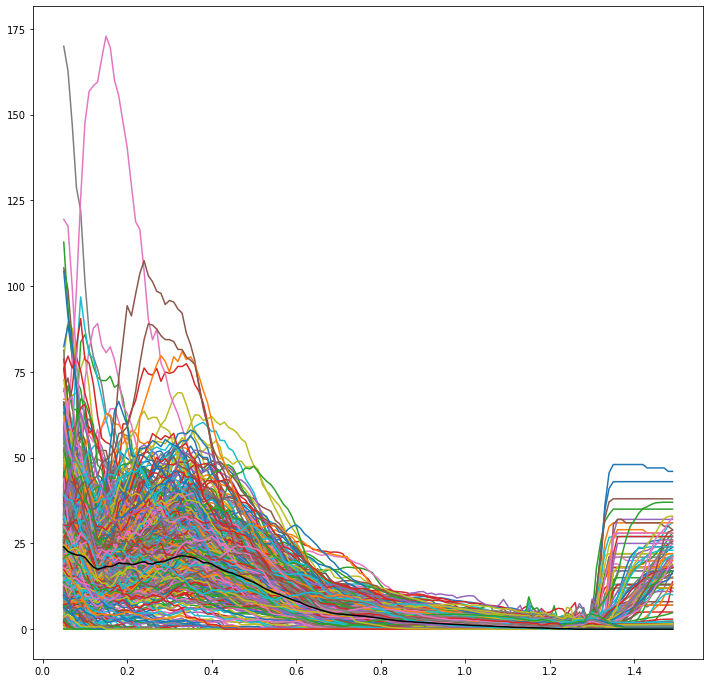

In [89]:
plt.figure(figsize = (12, 12))
for i in range(880):
    if len(background_s[i]) > 0:
        plt.plot(z_bins, background_s[i][0], "-")
        #plt.plot(z_bins, background_n[i][1], "-")
        #plt.plot(z_bins, background_n[i][2], "-")
plt.plot(z_bins, np.median(original_1_s, axis = 1), "-k")
plt.show()

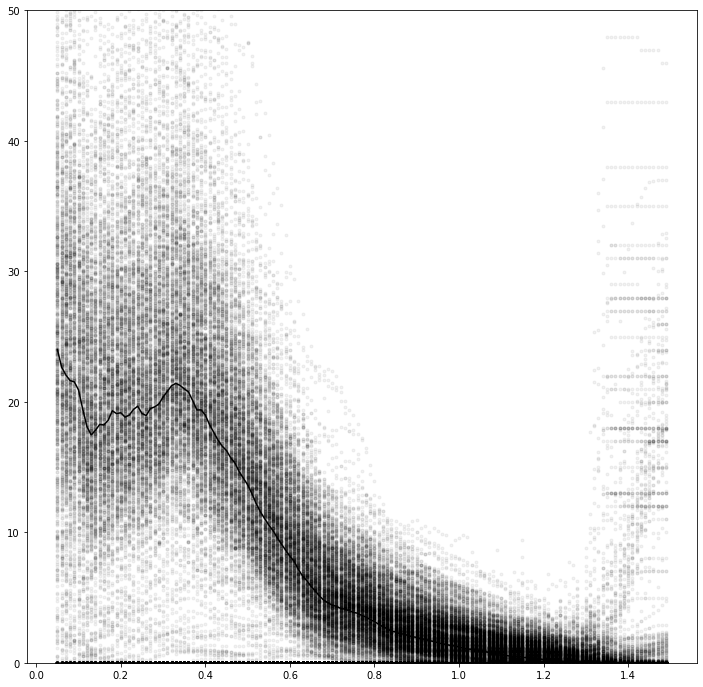

In [95]:
plt.figure(figsize = (12, 12))
for i in range(880):
    if len(background_s[i]) > 0:
        plt.plot(z_bins, background_s[i][0], ".k", alpha = 0.05)
        #plt.plot(z_bins, background_n[i][1], "-")
        #plt.plot(z_bins, background_n[i][2], "-")
plt.plot(z_bins, np.median(original_1_s, axis = 1), "-k")
plt.ylim(0, 50)
plt.show()

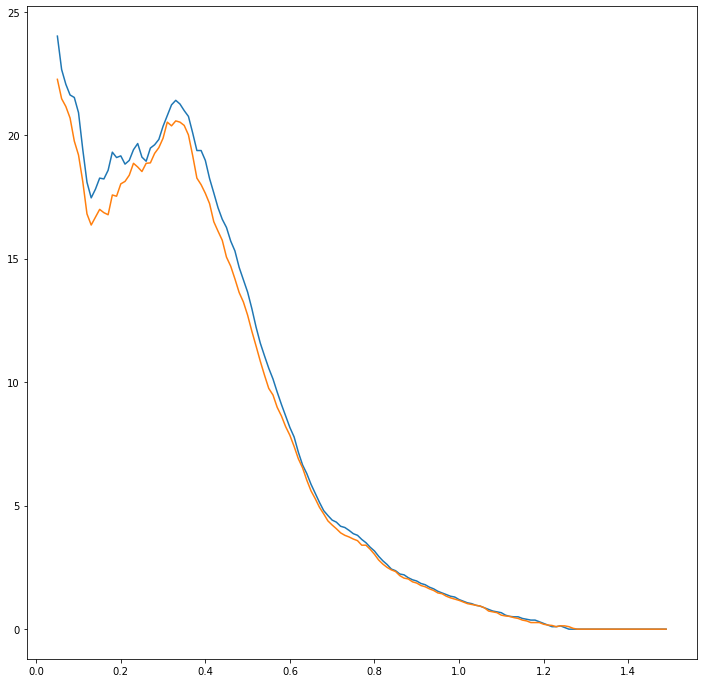

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [94]:
final_s = pd.read_csv("~/south_background_final2.csv")

plt.figure(figsize = (12, 12))
plt.plot(z_bins, np.median(original_1_s, axis = 1))
plt.plot(final_s.z, final_s["1mpcbkgd"])

In [91]:
np.save("third_south_monte_carlo_background_1", original_1_s)
np.save("third_south_monte_carlo_background_05", original_05_s)
np.save("third_south_monte_carlo_background_01", original_01_s)

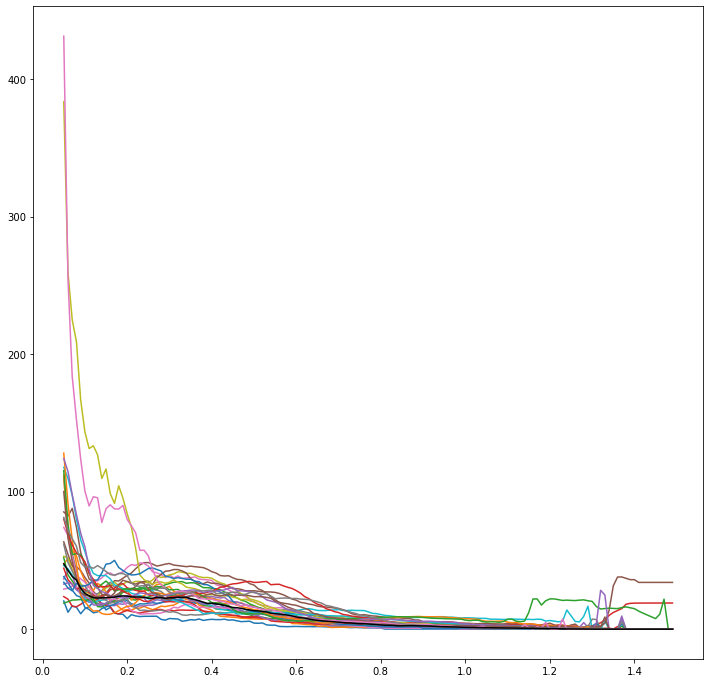

In [95]:
plt.figure(figsize = (12, 12))
for i in range(44):
    if len(background_s[i]) > 0:
        plt.plot(z_bins, background_s[i][0], "-")
        #plt.plot(z_bins, background_n[i][1], "-")
        #plt.plot(z_bins, background_n[i][2], "-")
plt.plot(z_bins, np.median(original_1_s, axis = 1), "-k")
plt.show()

In [ ]:
plt.plot(z_bins, np.median(original_1, axis = 1))
plt.plot(z_bins, np.median(original_1_s, axis = 1), "-r")


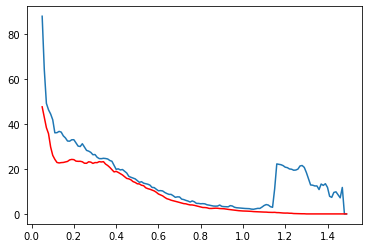

In [97]:
plt.plot(z_bins, np.median(original_1, axis = 1))
plt.plot(z_bins, np.median(original_1_s, axis = 1), "-r")


In [66]:
data_north = np.array([z_bins, np.median(original_1, axis = 1), np.median(original_05, axis = 1), np.median(original_01, axis = 1)])

In [67]:
data_north.shape

(4, 145)

In [68]:
pd_north = pd.DataFrame(data_north.T, columns = [["z", "1mpcbkgd", "halfmpcbkgd", "tenthmpcbkgd"]])

In [69]:
pd_north.to_csv("north_background_final_third.csv")

In [92]:
data_south = np.array([z_bins, np.median(original_1_s, axis = 1), np.median(original_05_s, axis = 1), np.median(original_01_s, axis = 1)])
pd_south = pd.DataFrame(data_south.T, columns = [["z", "1mpcbkgd", "halfmpcbkgd", "tenthmpcbkgd"]])

In [93]:
pd_south.to_csv("south_background_final_third.csv")

In [27]:
stars_s = pd.read_csv("south_background.csv")
no_stars_s = pd.read_csv("south_background_no_star.csv")
final_s = pd.read_csv("south_background_final.csv")

In [3]:
no_stars_n = pd.read_csv("north_background_no_star.csv")
stars_n = pd.read_csv("north_background.csv")

In [4]:
stars_s

,Unnamed: 0,z,1mpcbkgd,halfmpcbkgd,tenthmpcbkgd
0,0,0.05,47.550000,11.466667,0.183333
1,1,0.06,42.833333,10.983333,0.150000
2,2,0.07,38.300000,9.700000,0.100000
3,3,0.08,35.650000,8.516667,0.066667
4,4,0.09,29.733333,7.050000,0.033333
...,...,...,...,...,...
140,140,1.45,0.000000,0.000000,0.000000
141,141,1.46,0.000000,0.000000,0.000000
142,142,1.47,0.000000,0.000000,0.000000
143,143,1.48,0.000000,0.000000,0.000000


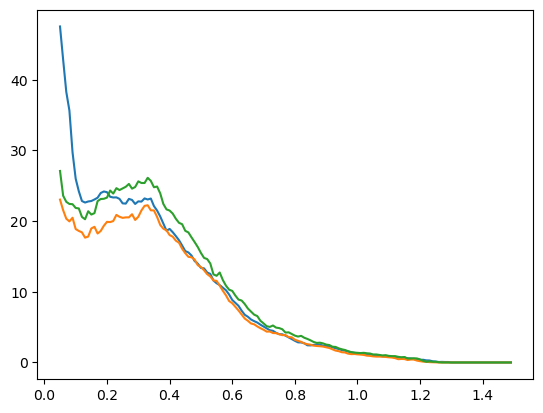

In [29]:
plt.plot(stars_s.z, stars_s["1mpcbkgd"])
plt.plot(no_stars_s.z, no_stars_s["1mpcbkgd"])
plt.plot(final_s.z, final_s["1mpcbkgd"])

In [30]:
no_stars_n = pd.read_csv("north_background_no_star.csv")
stars_n = pd.read_csv("north_background.csv")
final_n = pd.read_csv("north_background_final.csv")

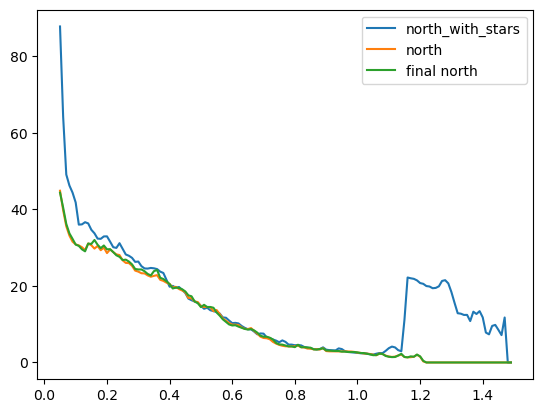

In [31]:
plt.plot(stars_n.z, stars_n["1mpcbkgd"], label = "north_with_stars")
plt.plot(no_stars_n.z, no_stars_n["1mpcbkgd"], label = "north")
plt.plot(final_n.z, final_n["1mpcbkgd"], label = "final north")
plt.legend()
plt.show()

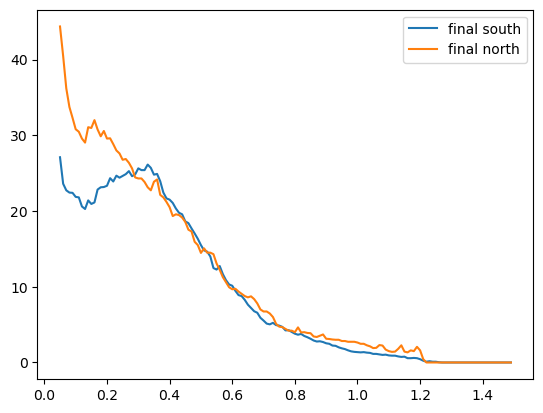

In [33]:
plt.plot(final_s.z, final_s["1mpcbkgd"], label = "final south")
plt.plot(final_n.z, final_n["1mpcbkgd"], label = "final north")
plt.legend()
plt.show()

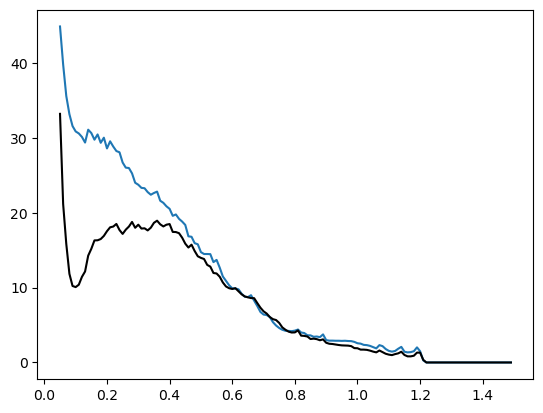

In [18]:
plt.plot(no_stars_n.z, no_stars_n["1mpcbkgd"])
plt.plot(z_bins, np.median(original_1, axis = 1), "-k")
plt.show()
#plt.plot(stars_n.z, stars_s["1mpcbkgd"])

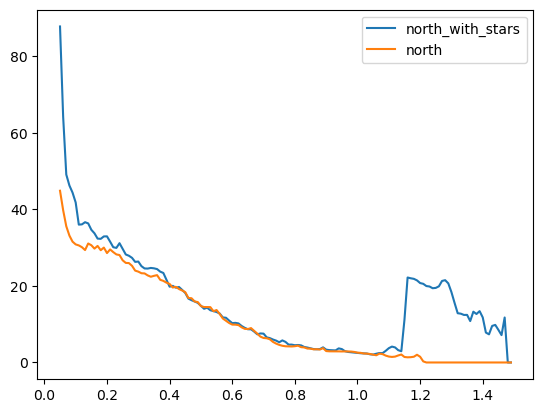

In [13]:
plt.plot(stars_n.z, stars_n["1mpcbkgd"], label = "north_with_stars")
plt.plot(no_stars_n.z, no_stars_n["1mpcbkgd"], label = "north")
plt.legend()
plt.show()

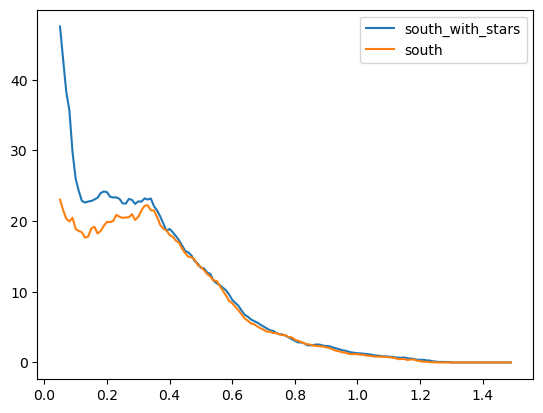

In [14]:
plt.plot(stars_s.z, stars_s["1mpcbkgd"], label = "south_with_stars")
plt.plot(no_stars_s.z, no_stars_s["1mpcbkgd"], label = "south")
plt.legend()
plt.show()